In [165]:
import pandas as pd
import numpy as np
from scaling import standardize, normalize
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from statistics import mean
from collections import Counter

import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from RandomForest import evaluate_rfc

In [166]:

df2015 = pd.read_csv('../data/kaasa/kaasa_2015.csv', index_col=None, header=0)
df2016 = pd.read_csv('../data/kaasa/kaasa_2016.csv', index_col=None, header=0)
df2017 = pd.read_csv('../data/kaasa/kaasa_2017.csv', index_col=None, header=0)
df2018 = pd.read_csv('../data/kaasa/kaasa_2018.csv', index_col=None, header=0)
df2019 = pd.read_csv('../data/kaasa/kaasa_2019.csv', index_col=None, header=0)
df2020 = pd.read_csv('../data/kaasa/kaasa_2020.csv', index_col=None, header=0)
df2021 = pd.read_csv('../data/kaasa/kaasa_2021.csv', index_col=None, header=0)

all_files = [df2015, df2016, df2017, df2018, df2019, df2020, df2021]

df = pd.concat(all_files, axis=0, ignore_index=True)

untouched_df = pd.concat(all_files, axis=0, ignore_index=True)

In [167]:
df = df.drop(columns=['source_id', 'individual', 'owner_id', 'name',  'distance', 'sin_time', 'cos_time', 'date_time',  'longitude', 'latitude', 'temperature', 'altitude'])
df = standardize(df, ['velocity', 'angle']) # standarize the data
df = normalize(df, ['velocity', 'angle'], 0, 1) # normalize the data

X = df.drop(['attack'], axis=1) # Features
y = df['attack'] # Target variable

In [38]:
# Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)

# Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=100, n_jobs=-1)

# Create Stratified K-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scoring = ('f1', 'recall', 'precision')

# Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)

# Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

Mean f1: 0.894
Mean recall: 0.900
Mean precision: 0.888


In [125]:
# Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)

# Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=100, n_jobs=-1)

# Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)

# SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)

Accuracy: 98.73 %
[[23354   257]
 [   48   291]]
              precision    recall  f1-score   support

           0      0.998     0.989     0.994     23611
           1      0.531     0.858     0.656       339

    accuracy                          0.987     23950
   macro avg      0.764     0.924     0.825     23950
weighted avg      0.991     0.987     0.989     23950



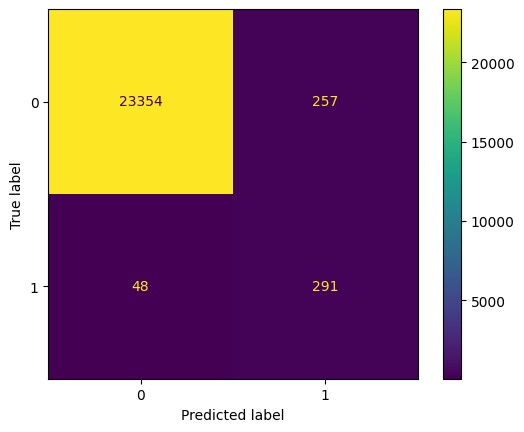

In [126]:
evaluate_rfc(SMOTE_SRF, y_test, y_pred)

In [170]:
y_pred_count = Counter(y_pred)
y_test_count = y_test.value_counts()

print('y_test (faktisk):\n', y_test_count)
print('y_pred (predikert):', y_pred_count)

y_test (faktisk):
 0    23611
1      339
Name: attack, dtype: int64
y_pred (predikert): Counter({0: 23402, 1: 548})


In [171]:
# Get the feature importances of the trained model
feature_importances = SMOTE_SRF.feature_importances_

# Sort the feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Print the top 10 features and their importances
for i in range(X.shape[1]):
    feature_idx = sorted_idx[i]
    print(f"{i+1}. {X.columns[feature_idx]} ({feature_importances[feature_idx]:.3f})")

# Select the top 10 most important features
top_k_features = X.columns[sorted_idx[:10]]

# Compute the average values of the top 10 features for false positives
X_false_positives_top_k = X_false_positives[top_k_features]
mean_false_positives = X_false_positives_top_k.mean(axis=0)

# Compute the average values of the top 10 features for true positives
X_true_positives_top_k = X_true_positives[top_k_features]
mean_true_positives = X_true_positives_top_k.mean(axis=0)

# Compute the average values of the top 10 features for false negatives
X_false_negatives_top_k = X_false_negatives[top_k_features]
mean_false_negatives = X_false_negatives_top_k.mean(axis=0)

# Compute the average values of the top 10 features for true negatives
X_true_negatives_top_k = X_true_negatives[top_k_features]
mean_true_negatives = X_true_negatives_top_k.mean(axis=0)

# Print the mean feature values for false positives and true positives
print("Mean feature values for false positives:")
print(mean_false_positives)
print("\nMean feature values for true positives:")
print(mean_true_positives)
print("\nMean feature values for false negatives:")
print(mean_false_negatives)
print("\nMean feature values for true negatives:")
print(mean_true_negatives)

1. velocity (0.543)
2. angle (0.457)
Mean feature values for false positives:
velocity    0.004200
angle       0.508392
dtype: float64

Mean feature values for true positives:
velocity    0.003483
angle       0.544903
dtype: float64

Mean feature values for false negatives:
velocity    0.000759
angle       0.541451
dtype: float64

Mean feature values for true negatives:
velocity    0.004275
angle       0.536488
dtype: float64


In [172]:
# Get the indices of the false positives
# the first condition checks if the predicted label is 1, and the second condition checks if the true label is 0
false_positives_idx = (y_pred == 1) & (y_test == 0)
true_positives_idx = (y_pred == 1) & (y_test == 1)

false_negatives_idx = (y_pred == 0) & (y_test == 1)
true_negatives_idx = (y_pred == 0) & (y_test == 0)

# Filter the rows of X_test that correspond to false positives
false_positives = X_test[false_positives_idx]
true_positives = X_test[true_positives_idx]
false_negatives = X_test[false_negatives_idx]
true_negatives = X_test[true_negatives_idx]

print('False positives:', len(false_positives))
print('True positives:', len(true_positives))
print('False negatives:', len(false_negatives))
print('True negatives:', len(true_negatives))

False positives: 257
True positives: 291
False negatives: 48
True negatives: 23354


In [193]:
tp_df = untouched_df.iloc[true_positives.index]
tn_df = untouched_df.iloc[true_negatives.index]
fp_df = untouched_df.iloc[false_positives.index]
fn_df = untouched_df.iloc[false_negatives.index]

In [186]:
# De som er predikert 1 og er faktisk 1
print('True positive mean velocity:', round(tp_df['velocity'].mean(), 2))
print('True positive mean angle:', round(tp_df['angle'].mean(), 2))
print('--------------------------------------------------')

# De som er predikert til 1 og er faktisk 0
print('False positive mean velocity:', round(fp_df['velocity'].mean(), 2))
print('False positive mean angle:', round(fp_df['angle'].mean(), 2))
print('--------------------------------------------------')

# De som er predikert til 0 men er faktisk 1
print('False negative mean velocity:', round(fn_df['velocity'].mean(), 2))
print('False negative mean angle:', round(fn_df['angle'].mean(), 2))
print('--------------------------------------------------')

# De som er predikert til 0 og er faktisk 0
print('True negative mean velocity:', round(tn_df['velocity'].mean(), 2))
print('True negative mean angle:', round(tn_df['angle'].mean(), 2))


True positive mean velocity: 78.78
True positive mean angle: 98.08
--------------------------------------------------
False positive mean velocity: 94.98
False positive mean angle: 91.51
--------------------------------------------------
False negative mean velocity: 17.17
False negative mean angle: 97.46
--------------------------------------------------
True negative mean velocity: 96.67
True negative mean angle: 96.57


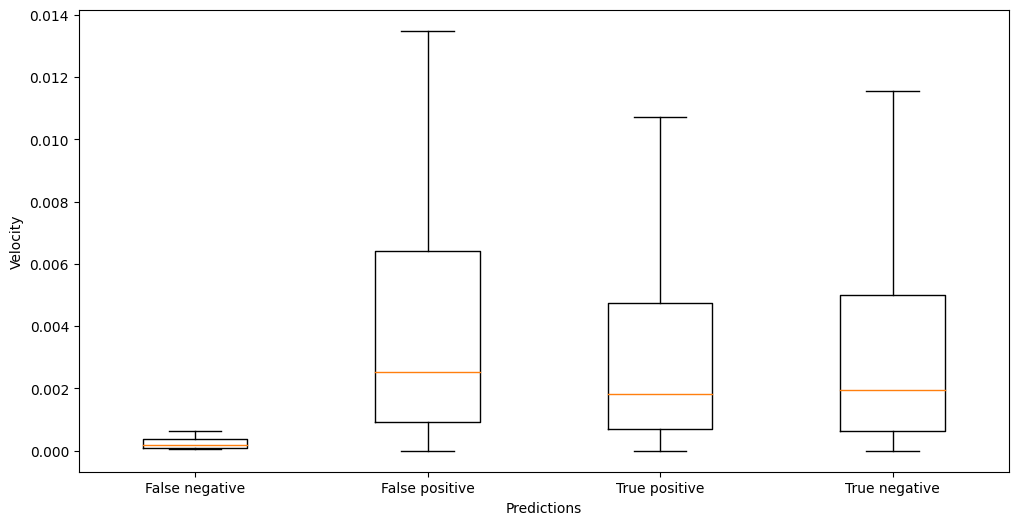

In [202]:
tot_df = [false_negatives, false_positives, true_positives, true_negatives]

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Create boxplot
ax.boxplot([df['velocity'] for df in tot_df], showfliers=False)

# Set x-axis tick labels
ax.set_xticklabels(['False negative', 'False positive', 'True positive', 'True negative'])

# Set axis labels
ax.set_xlabel('Predictions')
ax.set_ylabel('Velocity')

# Show plot
plt.show()

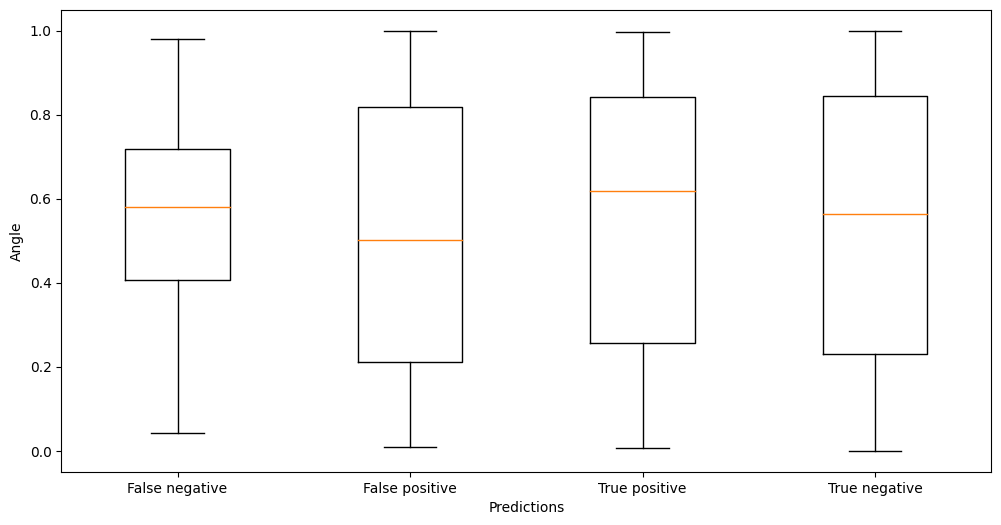

In [203]:
tot_df = [false_negatives, false_positives, true_positives, true_negatives]

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Create boxplot
ax.boxplot([df['angle'] for df in tot_df], showfliers=False)

# Set x-axis tick labels
ax.set_xticklabels(['False negative', 'False positive', 'True positive', 'True negative'])

# Set axis labels
ax.set_xlabel('Predictions')
ax.set_ylabel('Angle')

# Show plot
plt.show()

# Evaluation and vizualisation matrix

### Feature importances

angle importance:  0.5433206533960893
velocity importance:  0.45667934660391085


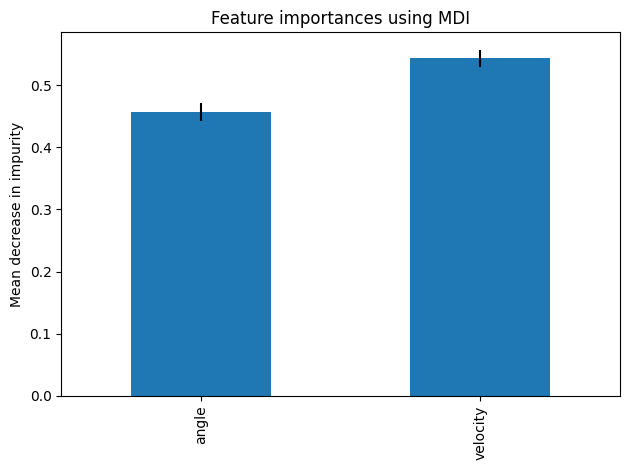

In [207]:
# Get feature importances
importances = SMOTE_SRF.feature_importances_

feature_names = df.columns[:-1]
std = np.std([tree.feature_importances_ for tree in SMOTE_SRF.estimators_], axis=0)

for i, feature in enumerate(X_train.columns):
    print(feature, 'importance: ', importances[i-1])

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Partial dependence plots
You can create partial dependence plots to visualize the relationship between a specific feature and the predicted outcome. This can help to identify how changes in a specific feature impact the model's predictions.

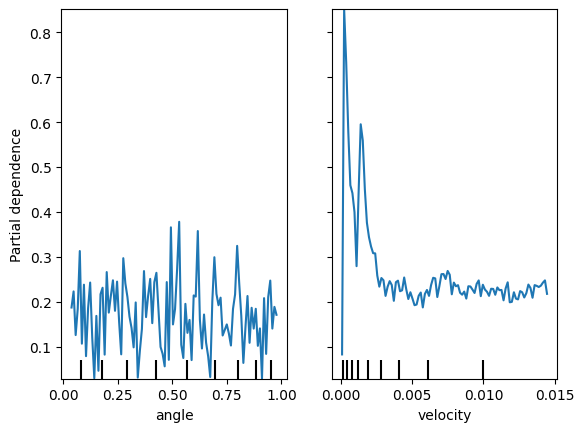

In [211]:
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(SMOTE_SRF, X, features=[0, 1])

### ROC Curve
A ROC curve can show the trade-off between sensitivity and specificity of the model. This can help to visualize the model's performance across different thresholds.

roc_auc_score for RandomForestClassifier:  0.9237611612706392
Best threshold: 1


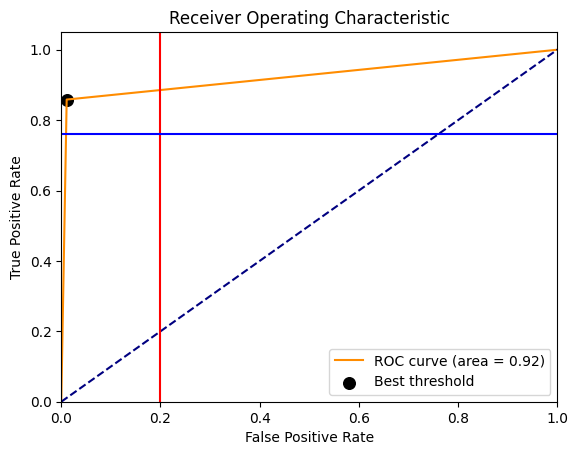

In [212]:
create_roc_curve(y_test=y_test, y_pred=y_pred)

### Tree graph